<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Градиентный-бустинг-catboost" data-toc-modified-id="Градиентный-бустинг-catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Градиентный бустинг catboost</a></span></li><li><span><a href="#LightGBM-для-регрессии" data-toc-modified-id="LightGBM-для-регрессии-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM для регрессии</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Предсказание заказов такси

Чтобы привлекать больше водителей в период пиковой нагрузки у аэропортов, нужно спрогнозировать количество заказов такси на следующий час. Построим модели для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [48]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import mean_squared_error


import matplotlib.pyplot as plt 
from IPython.display import display

## Подготовка

Загрузим данные и выполним их ресемплирование по одному часу.


In [49]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Чтобы работать с временными рядами, необходимо проверить, в хронологическом ли порядке расположены даты и время:

In [50]:
df.index.is_monotonic

True

Дата и время расположены в хронологическом порядке. 

In [51]:
df.head(2)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


In [52]:
df.tail(2)

,num_orders
datetime,
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


**Описание данных**

Количество заказов находится в столбце 'num_orders', данные даны за каждые десять минут.

Временной интервал дан за 2018й год, с 1го марта по 31ое августа.

Проверим, есть ли в данных пропуски:

In [53]:
df['num_orders'].isna().sum()

0

Выполним ресемплирование по одному часу.

Ресемплирование — это изменение интервала со значениями ряда. 
Агрегировать будем по сумме за один час.

In [54]:
df = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime'>

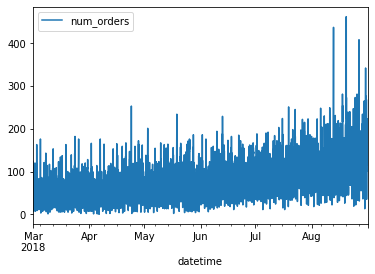

In [55]:
df.plot()

Опираясь на текущий график явно ничего сказать нельзя, необходим более подробный анализ данных.

## Анализ


Проанализируем данные.

Построим график за первый месяц, cкользящим средним сгладим графики:

<AxesSubplot:xlabel='datetime'>

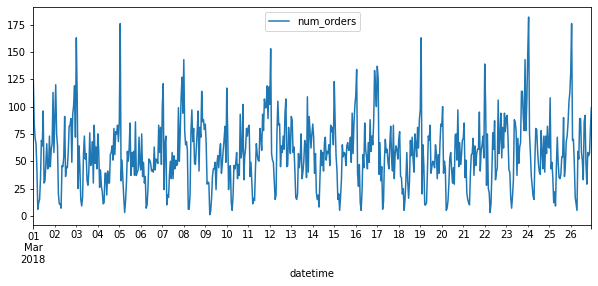

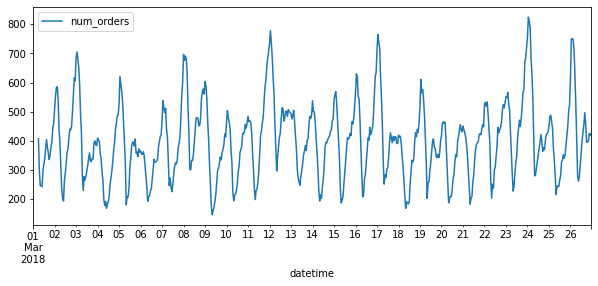

In [56]:
df['2018-03-01':'2018-03-26'].plot(figsize=(10,4)) 
df['2018-03-01':'2018-03-26'].rolling(7).sum().plot(figsize=(10,4)) 

Пoстроим график за первые два дня:

<AxesSubplot:xlabel='datetime'>

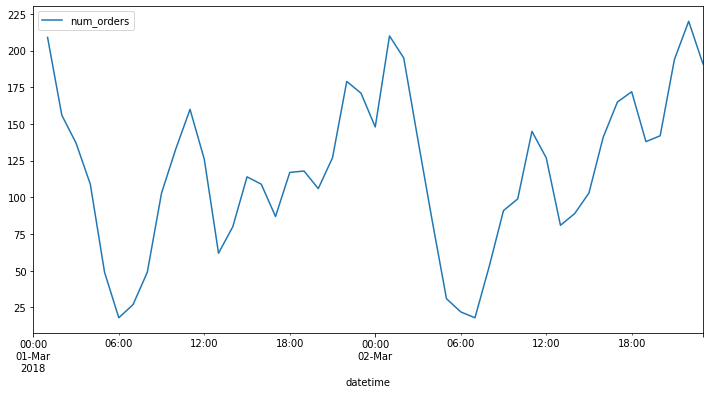

In [57]:
df['2018-03-01':'2018-03-02'].rolling(2).sum().plot(figsize=(12,6)) 

Из графиков видно, что ночью в районе 5-6 утра очень мало заказов, а также есть пики в районе полуночи.

Посмотрим на присутствие тренда и сезонности в данных:

In [58]:
decomposed = seasonal_decompose(df) 

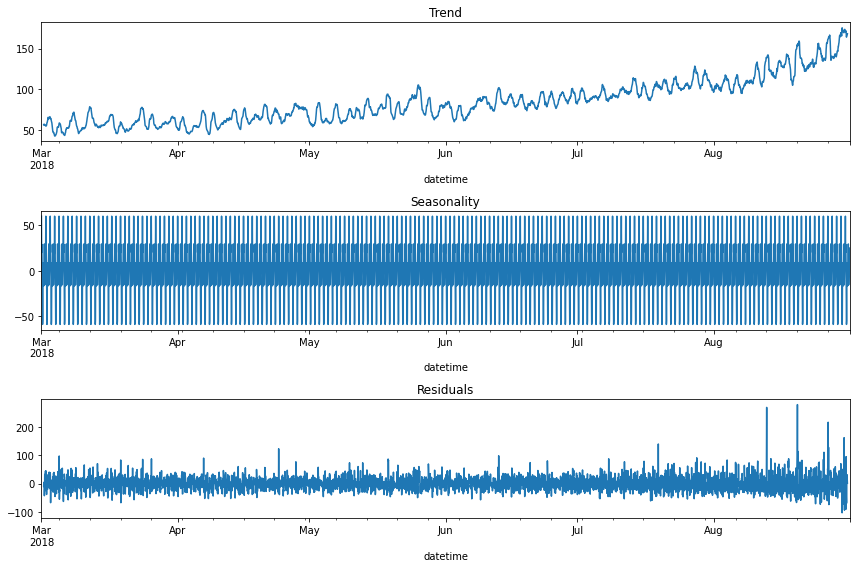

In [59]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Из графиков видно, что в течение марта-августа 2018го года присутствует тренд по увеличению заказов такси из аэропорта. Возможно, летом больше людей куда-то летят, на отдых или к друзьям.

Также видно, что в данных присутствует сезонность, посмотрим на неё за день:

Text(0.5, 1.0, 'Seasonality')

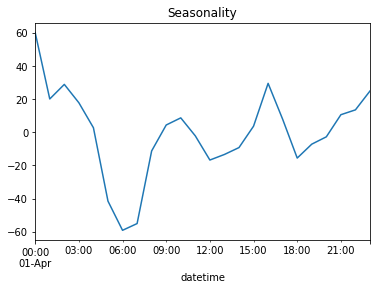

In [60]:
decomposed.seasonal['2018-04-01':'2018-04-1'].plot(ax=plt.gca())
plt.title('Seasonality')

Есть пики в районе девяти утра, четырёх вечера и полуночи. А также есть основной провал в заказах в районе шести утра. Видимо такая сезонность связана с расписанием регулярных рейсов в аэропорту.

## Обучение


Создадим из выборки признаки для моделей:
- календарные признаки
- «Отстающие значения»
- Скользящее среднее

Календарные признаки:

In [61]:
df['dayofweek'] = df.index.dayofweek
df['hour'] = df.index.hour

Какие факторы подходят для данного проекта:

- Фактор год: НЕТ, однозначно не подходит. У нас данных меньше года. Поэтому будет просто константа. 
- Фактор месяц: НЕТ, аналогично году, у нас в истории всего один март, май.... Да и горизоно прогноза - часы. Поэтому сезонность времени года будет просто в тренде уже заложена.
- Фактор день: НЕТ, также не подходит, будет просто последовательность чисел
- Фактор день недели: ДА, т.к. у нас есть недельная сезонность
- Фактор час: ДА, т.к. есть часовая (суточная) сезонность.
- Факто lag: ДА, это параметр авторегрессии - учёт влияния вчерашних событий на сегодняшние.
- Фактор rolling: ДА, это аналог тренда. Чем больше окно сглаживания, тем ровнее линия тренда

Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. Получим отстающие значения методом shift():

In [62]:
max_lag = 2
for lag in range(1, max_lag + 1):
  df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

Скользящее среднее как признак задаёт общий тренд временного ряда. Скользящее среднее в моменте t учитывает текущее значение ряда x(t). Это некорректно: целевой признак «убежал» в признаки. Вычисление скользящего среднего не должно включать в себя текущее значение ряда:

In [63]:
rolling_mean_size = 24
df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

Пару строк по фактору лаг и скользящее среднее:

- Lag:
Его называют ещё параметром авторегрессии. Допустим lag=1 - учитывает (для удобства будем считать, что продажи собраны по дням) как вчерашние продажи - вчерашние события - влияли на сегоняшние.Lag=2: учитывает как позавчерашние продажи влияют на сегодняшние.....
    
- По скользящему среднего:
Предположим rolling=10 - скользящее среднее. По сути, ищем среднее по 10 точкам, потом следующие 10 точек, и т.д. - это некое подобие тренда будет - средней линии. Т.е. - сглаживание колебаний/выбросов. Это легко увидеть на пределе: допустим длина ряда 100 дней. rolling(100) - это просто одно число - среднее всего ряда. <br>
    
Поэтому, если выставить сезонности - час и день недели, то дополнительные факторы могут быть такие: лаг =1 (максимум 2), а скользящее среднее = 24 (среднее за сутки). 

Начнём с этого. В итоге модель будет приемлемая по точности и не много факторов.

Посмотрим на получившийся датафрейм:

In [64]:
df.head(12)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,NaN


В данных в первых строках появились значения NaN. Часть моделей не работают с такими данными. Удалим строки, в которых есть такие пропуски.

In [65]:
df = df.dropna()

In [66]:
df.head(2)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-02 00:00:00,90,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,120,4,1,90.0,58.0,55.416667


Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.

Перемешивать выборки в задаче прогнозирования временного ряда нельзя. Данные обучающей выборки должны предшествовать данным тестовой. Иначе тестирование модели будет некорректным: модель не должна обучаться на данных из будущего. 

In [67]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


 Выделим признаки и целевой признак.

In [68]:
train_X = train.drop('num_orders', axis=1)
train_y = train['num_orders']
test_X = test.drop('num_orders', axis=1)
test_y = test['num_orders']

Данные разбиты корректно: в тренировочную выборку попали данные за март-начало августа, а в тестовую за вторую половину августа.

### Линейная регрессия

In [69]:
model = LinearRegression()
model.fit(train_X,train_y)

LinearRegression()

### Решающее дерево

Найдём наилучшую модель с помощью кросс валидации.

In [70]:
best_model_tree_r = None
best_result_r = 100000
best_depth = None
for depth in range(1, 12):
  model_tree_r = DecisionTreeRegressor(random_state=12345, max_depth=depth) 
  model_tree_r.fit(train_X, train_y) # обучим модель на тренировочных данных

  train_predictions = model_tree_r.predict(train_X) # получим предсказания модели
  
  smape_tree_r = abs(cross_val_score(model_tree_r, train_X, train_y,   # посчитаем качество модели sMAPE
                             scoring = make_scorer(mean_squared_error, greater_is_better=False),
                             cv = 5,
                             n_jobs = -1).mean()) 
   
  print (f'sMape для тренировочной выборки: {smape_tree_r:.2f}, глубина дерева: {depth}')
  if smape_tree_r < best_result_r:
    best_model_tree_r = model_tree_r
    best_result_r = smape_tree_r
    best_depth = depth
        
print()
print(f"Лучшая глубина дерева, {best_depth}, а RMSE {best_result_r:.2f}")

sMape для тренировочной выборки: 1300.01, глубина дерева: 1
sMape для тренировочной выборки: 1220.04, глубина дерева: 2
sMape для тренировочной выборки: 984.95, глубина дерева: 3
sMape для тренировочной выборки: 898.05, глубина дерева: 4
sMape для тренировочной выборки: 802.91, глубина дерева: 5
sMape для тренировочной выборки: 787.66, глубина дерева: 6
sMape для тренировочной выборки: 809.43, глубина дерева: 7
sMape для тренировочной выборки: 833.19, глубина дерева: 8
sMape для тренировочной выборки: 863.28, глубина дерева: 9
sMape для тренировочной выборки: 894.01, глубина дерева: 10
sMape для тренировочной выборки: 952.83, глубина дерева: 11

Лучшая глубина дерева, 6, а RMSE 787.66


### Градиентный бустинг catboost

Создадим и обучим модель catboost. Чтобы подобрать оптимальные параметры для модели воспользуемся GridSearchCV.

Разделим тренировочную выборку на тренировочную и валидационную выборки. Оценим размер получившихся выборок.

In [71]:
train_cat, val_cat = train_test_split(train, shuffle=False, test_size=0.1)
print(train_cat.index.min(), train_cat.index.max())
print(val_cat.index.min(), val_cat.index.max())

2018-03-02 00:00:00 2018-07-28 03:00:00
2018-07-28 04:00:00 2018-08-13 15:00:00


 Выделим признаки и целевой признак .

In [72]:
train_cat_X = train_cat.drop('num_orders', axis=1)
train_cat_y = train_cat['num_orders']
val_cat_X = val_cat.drop('num_orders', axis=1)
val_cat_y = val_cat['num_orders']

In [73]:
cat_model = CatBoostRegressor()

In [74]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'l2_leaf_reg': [1, 3, 5, 7]}

In [75]:
#  Подобрала параметры в google collab, закомментировала, чтобы код выполнялся быстрее
"""
Grid_CBC = GridSearchCV(estimator=cat_model, param_grid = grid, cv = 2, n_jobs=-1)
Grid_CBC.fit(train_X, train_y)
"""

'\nGrid_CBC = GridSearchCV(estimator=cat_model, param_grid = grid, cv = 2, n_jobs=-1)\nGrid_CBC.fit(train_X, train_y)\n'

In [76]:
# Grid_CBC.best_params_

In [77]:
params = {'learning_rate': 0.03,
          'depth': 4,
          'l2_leaf_reg': 5,
          'random_state':42,
          'iterations':1000,
          'verbose': 100}

In [78]:
cat_model = CatBoostRegressor(**params)

In [96]:
cat_model.fit(train_X, train_y, eval_set=(val_cat_X,val_cat_y))

0:	learn: 38.1809543	test: 55.2232936	best: 55.2232936 (0)	total: 1.49ms	remaining: 1.49s
100:	learn: 25.3106453	test: 34.5753010	best: 34.5753010 (100)	total: 107ms	remaining: 950ms
200:	learn: 23.9881051	test: 30.9172935	best: 30.9172935 (200)	total: 206ms	remaining: 821ms
300:	learn: 23.1599899	test: 29.0218131	best: 29.0218131 (300)	total: 311ms	remaining: 723ms
400:	learn: 22.5094950	test: 27.5566197	best: 27.5566197 (400)	total: 412ms	remaining: 615ms
500:	learn: 21.7259766	test: 26.2437423	best: 26.2437423 (500)	total: 518ms	remaining: 516ms
600:	learn: 21.2239672	test: 25.3476336	best: 25.3476336 (600)	total: 640ms	remaining: 425ms
700:	learn: 20.8207229	test: 24.5369907	best: 24.5369907 (700)	total: 759ms	remaining: 324ms
800:	learn: 20.4715795	test: 23.9456167	best: 23.9456167 (800)	total: 868ms	remaining: 216ms
900:	learn: 20.1085760	test: 23.3448824	best: 23.3448824 (900)	total: 986ms	remaining: 108ms
999:	learn: 19.7930233	test: 22.8430282	best: 22.8430282 (999)	total: 1.1

###  LightGBM для регрессии

Создадим и обучим модель LightGBM. Чтобы подобрать оптимальные параметры для модели воспользуемся GridSearchCV.

In [80]:
# Аналогично, grid search подобран в коллабе, здесь код выполняется очень долго
"""
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
              'num_leaves' :[20,40,60],
              'n_estimators':[40,50,60]             
             }

gbm = lgb.LGBMRegressor(objective='regression')

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(train_X, train_y)
"""

"\nparam_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],\n              'max_depth': [15, 20, 30, 35],\n              'num_leaves' :[20,40,60],\n              'n_estimators':[40,50,60]             \n             }\n\ngbm = lgb.LGBMRegressor(objective='regression')\n\n# инициализируем GridSearchCV\ngrid_search = GridSearchCV(estimator = gbm, \n                           param_grid = param_grid, \n                           cv = 3,\n                           n_jobs = -1, \n                           verbose = 0, \n                           scoring = 'neg_mean_squared_error',\n                          )\ngrid_search.fit(train_X, train_y)\n"

In [81]:
# grid_search.best_params_

In [82]:
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=40,learning_rate=0.1, n_estimators=60, max_depth=15)

In [83]:
gbm.fit(train_X, train_y)

LGBMRegressor(max_depth=15, n_estimators=60, num_leaves=40,
              objective='regression')

## Тестирование

Чтобы проверять качество моделей возьмём метрику RMSE. Спрогнозировать временные ряды без обучения можно следующим способом:

Новое значение x(t) прогнозируется предыдущим значением ряда, то есть x(t-1).


In [84]:
pred_previous = test['num_orders'].shift()
pred_previous.iloc[0] = train['num_orders'].iloc[-1]
rmse_simple = mean_squared_error(pred_previous, test['num_orders'])**0.5
print("RMSE:", rmse_simple)

RMSE: 58.881776776551476


А нам необходимо добиться метрики RMSE не более 48!

**Линейная регрессия**

In [85]:
test_pred = model.predict(test_X)

In [86]:
lin_rmse =  mean_squared_error(test_y,test_pred)**0.5
print("RMSE тестовой выборки: ", lin_rmse)

RMSE тестовой выборки:  51.29636818907293


RMSE тестовой выборки почти такое же как на искусственном предсказании по предыдущему значению!

**Решающее дерево**

In [87]:
pred_test = best_model_tree_r.predict(test_X)

In [88]:
tree_rmse = mean_squared_error(test_y, pred_test)**(1/2)
print("RMSE тестовой выборки: ", tree_rmse)

RMSE тестовой выборки:  52.854859956492774


**Градиентный бустинг catboost**

In [97]:
pred_test = cat_model.predict(test_X) 

In [98]:
catb_rmse = mean_squared_error(test_y, pred_test)**(1/2)
print("RMSE тестовой выборки: ", catb_rmse)

RMSE тестовой выборки:  49.229964358137984


**LightGBM для регрессии**

In [91]:
pred_test_gbm = gbm.predict(test_X) 

In [92]:
gbm_rmse = mean_squared_error(test_y, pred_test_gbm)**(1/2)

print("RMSE тестовой выборки: ", gbm_rmse)

RMSE тестовой выборки:  43.58529160560325


### Вывод

In [99]:
print('RMSE полученные при двух лагах')
pd.DataFrame({
    'Model' : ['rmse'],
    'Not_predict' : [rmse_simple],
    'Lin_reg' : [lin_rmse],
    'Dec_Tree' : [tree_rmse],
    'Catboost' : [catb_rmse],
    'Light_GBM' : [gbm_rmse]
})

RMSE полученные при двух лагах


,Model,Not_predict,Lin_reg,Dec_Tree,Catboost,Light_GBM
0,rmse,58.881777,51.296368,52.85486,49.229964,43.585292


In [94]:
print('RMSE полученные при одном лаге')
pd.DataFrame({
    'Model' : ['rmse'],
    'Not_predict' : [58.881777],
    'Lin_reg' : [51.220001],
    'Dec_Tree' : [51.740716],
    'Catboost' : [50.210816],
    'Light_GBM' : [43.735659]
})

RMSE полученные при одном лаге


,Model,Not_predict,Lin_reg,Dec_Tree,Catboost,Light_GBM
0,rmse,58.881777,51.220001,51.740716,50.210816,43.735659


Получили предсказания для тестовой выборки для четырёх моделей: линейной регрессии, решающего дерева, catboost и Light GBM.

Единственная модель, которая смогла вытянуть метрику это Light GBM.

## Общий вывод 

В ходе работы было выполнено:

- Загружены данные и проведена их предобработка.
- Обучено несколько моделей, наилучшие параметры моделей были подобраны с помощью кросс валидации и Grid Search.
- Выполнено сравнение моделей.
- Выбрана лучшая модель по результатам метрики RMSE.

Выбрали модель Light GBM, у неё единственный подходящий rmse.

In [108]:
predict_test_series = pd.Series(pred_test_gbm, index=test_y.index)

Выведем график сравнения предсказания и целевого признака:

<function matplotlib.pyplot.show(close=None, block=None)>

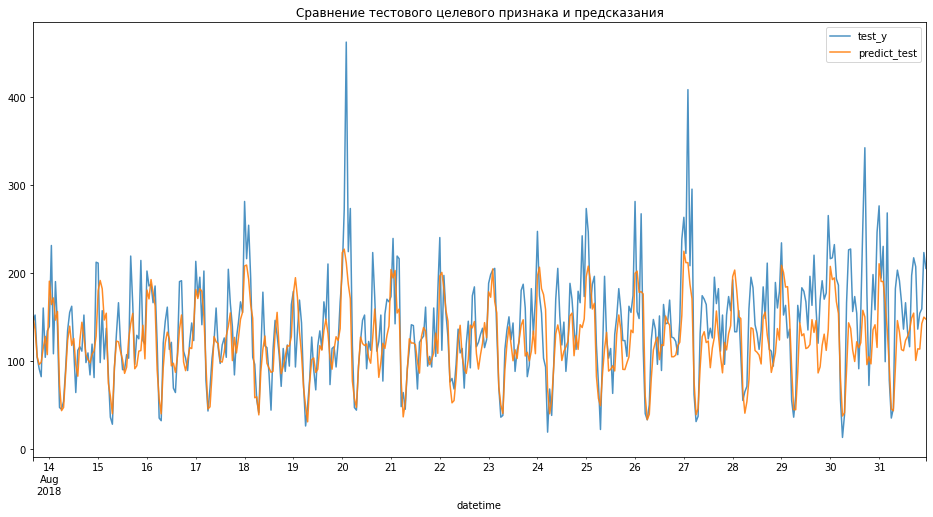

In [111]:
ax = test_y.plot(y='num_orders', figsize=(16,8), label='test_y', alpha=0.8)
predict_test_series.plot(figsize=(16,8), ax=ax, alpha=0.9, label='predict_test')
plt.title('Сравнение тестового целевого признака и предсказания')
plt.legend()
plt.show